# Démonstration de calcul sur les cartes cognitives

## Mise en place

On commence par le chargement des modules et des données

In [1]:
from itertools import islice, accumulate
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, Normalize
import seaborn as sns
import networkx as nx

from cog_maps import CogMaps, CM_LA_MINE_FILENAME, THESAURUS_FILENAME, WEIGHTS_MAP_FILENAME, DEFAULT_WEIGHTS, LEVELS
import vizu

thesaurus = CogMaps.load_thesaurus_map(THESAURUS_FILENAME)
weights = CogMaps.load_weights(WEIGHTS_MAP_FILENAME)
les_cartes = CogMaps(CM_LA_MINE_FILENAME)

On va regarder le contenu des 5 premières cartes et garder la toute première sous le coude.

In [2]:
for i, w in islice(les_cartes.cog_maps.items(), 5):
    print(i, w)
une_carte = les_cartes.cog_maps[1]


1 ['pollution', 'inondation', 'boom', 'travail', 'retombée']
2 ['richesse', 'malédiction', 'travail', 'destruction', 'histoire', 'frein', 'blocage', 'coutumier']
4 ['travail', 'pollution', 'plainte']
5 ['argent', 'pollution', 'nickel', 'production', 'nature', 'réparation', 'mer', 'inégalité']
6 ['extraction', 'montagne', 'pollution', 'mineur', 'train', 'diversité', 'évolution']


On va maintenant afficher les pondérations disponibles (il y en a 8) : une application qui à chaque position (ou chaque écart) $n$ fait correspondre un poids dans l'intervalle $[0, \ldots, 1]$

In [3]:
# la liste des pondérations définies
print(weights.keys())
# la pondération pos_3_arith 
weights["pos_3_arith"]

dict_keys(['arithmetique', 'inverse', 'pos_1', 'pos_3', 'pos_6', 'pos_3_arith', 'pos_6_arith', 'exponentielle'])


{1: 1.0,
 2: 0.5,
 3: 0.33,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0}

On va maintenant s'intéresser au thésaurus : une série de 3 applications qui à chaque mot fait correspondre un mot/concept qui le généralise :

- mot énoncé $\to$ concept
- concept    $\to$ mot mère
- mot mère   $\to$ mot grand mère

In [4]:
thesaurus.keys()

dict_keys(['concept', 'mother', 'gd_mother'])

Les niveaux du thésaurus permettent de généraliser les cartes : on peut remplacer chaque mot d'une carte par son concept, puis remplacer par le niveau suivant (mère) et encore celui d'après (grand-mère). C'est la composition ($\circ$) des applications associées à chaque niveau de thésaurus.

In [5]:
une_carte_concept = [thesaurus["concept"][mot] for mot in une_carte]
une_carte_mere = [thesaurus["mother"][mot] for mot in une_carte_concept]
le_carte_gd_mere = [thesaurus["gd_mother"][mot] for mot in une_carte_mere]

# exemple sur la première carte
for quad in zip(une_carte, une_carte_concept, une_carte_mere, le_carte_gd_mere):
    print(" -> ".join(quad))

pollution -> pollution -> pollution -> pollution
inondation -> inondation -> changement climatique -> dégradation environnementale
boom -> boom -> passé -> nouvelle-calédonie
travail -> emploi -> emploi -> travail
retombée -> retombée -> économie du pays -> économie


## Les calculs

Les cartes, les cartes "concepts", les cartes "mères" et les cartes "grands mères" sont toutes des objets du même type, on peut faire les trois calculs principaux :

- l'index qui à chaque mot donne ses occurences
- le calcul du nombre d'occurrence de chaque mot à chaque position
- le calcul du nombre d'occurrences, pondéré selon la position
- le calcul des co-occurrences entre couples de mots
  - ceci donne une matrice symétrique qui sert de base pour le rendu sous forme de graphe ou le clustering

In [6]:
# par exemple "doniambo" apparait 8 fois
les_cartes.index["doniambo"]

[(69, 2),
 (154, 4),
 (187, 4),
 (229, 3),
 (231, 5),
 (248, 4),
 (310, 8),
 (336, 14)]

In [7]:
# sans pondération on voit un poids de 8.0
les_cartes.occurrences["doniambo"]

8.0

In [8]:
# mais si on pondère, le score va être plus bas
les_cartes.weights = weights["pos_3_arith"]
# il apparait une fois en positions 2 et une fois en 3, avec ces poids il va avoir 1/2 + 1/3
les_cartes.occurrences["doniambo"]

0.8300000000000001

In [9]:
# on peut maintenant demander avec qui "doniambo" co-apparait comme mot voisin
les_cartes.weights = weights["pos_1"]
sorted(((poids, mot) for mot, poids in les_cartes.matrix["doniambo"].items() if poids > 0.0), reverse=True)

# on peut vérifier que le nombre total de co-occurences est bien de 16

[(8.0, 'doniambo'),
 (3.0, 'vale'),
 (2.0, 'nickel'),
 (1.0, 'yaté'),
 (1.0, 'vkp'),
 (1.0, 'tiébaghi'),
 (1.0, 'terre rouge'),
 (1.0, 'sln'),
 (1.0, 'métallurgie'),
 (1.0, 'métal'),
 (1.0, 'minerai'),
 (1.0, 'goro'),
 (1.0, 'exportation'),
 (1.0, 'camion')]

In [10]:
# ceci sera différent si on change de système de poids
les_cartes.weights = weights["exponentielle"]
# on se limite aux 10 premiers
sorted(((poids, mot) for mot, poids in les_cartes.matrix["doniambo"].items() if poids > 0.05), reverse=True)[1:11]


[(3.0, 'vale'),
 (2.7, 'nickel'),
 (1.7400000000000002, 'sln'),
 (1.3900000000000001, 'métal'),
 (1.37, 'terre rouge'),
 (1.37, 'camion'),
 (1.1400000000000001, 'yaté'),
 (1.1400000000000001, 'goro'),
 (1.1400000000000001, 'exportation'),
 (1.0, 'vkp')]

## L'exploitation des graphes/matrices

On a un matériel "classique", que l'on peut visualiser. On va garder ici la carte mère de la mine avec des poids exponentiels (inverse)

In [11]:
les_cartes_transformees, rapports = les_cartes.apply_many(thesaurus, with_unknown = False)
les_cartes_meres = les_cartes_transformees["mother"]
les_cartes_meres.weights = DEFAULT_WEIGHTS

In [12]:
# les 10 mots les plus cités
list(sorted(les_cartes_meres.occurrences.items(), key = lambda x : x[1], reverse = True))[:10]

[('impact environnemental', 255.0),
 ('emploi', 202.0),
 ('nickel', 196.0),
 ('pollution', 177.0),
 ('minerai', 129.0),
 ('économie du pays', 126.0),
 ('usine', 112.0),
 ('exploitation', 108.0),
 ('engin', 102.0),
 ('terre', 90.0)]

In [13]:
# on va passer maintenant à un syteme de poids exponentiel inverse
les_cartes_meres.weights = weights["exponentielle"]

Visualiser les co-occurrences. Soit 

- comme une matrice
- un graphe
- une _heatmap_

**TODO**: utiliser les poids pour le delta entre position **et** la position !

In [14]:
df = pd.DataFrame(les_cartes_meres.matrix).fillna(0.0)
df

,pollution,changement climatique,passé,emploi,économie du pays,richesse,vision négative de la ressource,impact environnemental,conflit,coutume,...,déclin,culture pop,développement durable,innovation,bien de consommation,puissance étrangère,structure,croissance minière,automatisation,crise
pollution,188.98,5.11,0.95,46.10,26.70,10.01,1.51,69.91,12.93,2.39,...,0.15,0.37,0.51,0.37,0.14,0.05,1.14,2.51,1.0,0.14
changement climatique,5.11,19.38,1.00,6.05,3.40,1.16,0.00,7.71,0.74,0.00,...,0.00,0.00,0.00,0.00,0.00,0.14,0.51,0.37,0.0,0.00
passé,0.95,1.00,17.02,3.25,0.76,1.19,1.14,1.20,0.65,0.93,...,0.00,0.14,0.00,0.00,0.00,0.05,0.00,0.00,0.0,0.37
emploi,46.10,6.05,3.25,212.00,39.07,17.00,2.83,47.05,20.18,1.42,...,0.74,0.02,1.02,0.04,1.40,1.43,0.75,0.43,0.0,0.47
économie du pays,26.70,3.40,0.76,39.07,128.84,9.38,0.14,45.10,13.11,2.37,...,1.00,0.00,0.12,0.00,0.00,1.14,0.00,0.14,0.0,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
revalorisation de la ressource,0.02,0.00,1.28,0.38,1.14,0.40,0.00,1.56,0.14,1.07,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.39
maintien de l’exploitation,0.00,0.00,0.00,0.74,0.00,1.14,0.00,0.44,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.19
bien de consommation,0.14,0.00,0.00,1.40,0.00,0.28,0.00,0.44,0.00,1.00,...,0.00,0.00,0.00,0.00,5.10,0.00,0.00,0.00,0.0,0.00
fin,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


In [15]:
df.describe()

,pollution,changement climatique,passé,emploi,économie du pays,richesse,vision négative de la ressource,impact environnemental,conflit,coutume,...,déclin,culture pop,développement durable,innovation,bien de consommation,puissance étrangère,structure,croissance minière,automatisation,crise
count,90.00,9.00e+01,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,...,9.00e+01,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00
mean,6.98,7.20e-01,0.66,7.72,4.83,2.84,0.32,10.02,3.35,0.62,...,1.63e-01,0.14,0.13,0.14,0.22,0.24,0.31,0.21,0.04,0.24
std,21.64,2.35e+00,1.89,23.52,14.97,8.17,1.00,34.73,10.13,1.79,...,5.26e-01,0.45,0.42,0.44,0.68,0.73,1.16,0.66,0.19,0.74
min,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.96,0.00e+00,0.00,1.12,0.16,0.05,0.00,1.42,0.15,0.00,...,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.87,5.00e-03,0.01,2.37,1.39,1.00,0.00,3.15,1.08,0.06,...,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.78,4.57e-01,0.99,5.42,3.53,2.21,0.06,6.99,3.09,1.00,...,7.50e-03,0.02,0.00,0.00,0.02,0.05,0.05,0.11,0.00,0.14
max,188.98,1.94e+01,17.02,212.00,128.84,73.00,8.10,319.72,92.76,16.10,...,4.00e+00,3.00,3.00,3.00,5.10,6.00,10.14,5.00,1.00,6.00


In [16]:
df["impact environnemental"].sort_values(ascending=False)

impact environnemental    319.72
pollution                  69.91
emploi                     47.05
économie du pays           45.10
nickel                     30.11
                           ...  
formation                   0.01
innovation                  0.00
culture pop                 0.00
développement culturel      0.00
fin                         0.00
Name: impact environnemental, Length: 90, dtype: float64

La visulation de la matrice sous forme de graphe, en ne prenant en compte que les co-occcurrences $\geq 9.0$

![](dist/cartes_cog_la_mine_mother_exponentielle_9.0.svg)

Une gallerie de $4 \times 8$ graphes : chacun des 4 niveaux et 8 seuils de filtrage

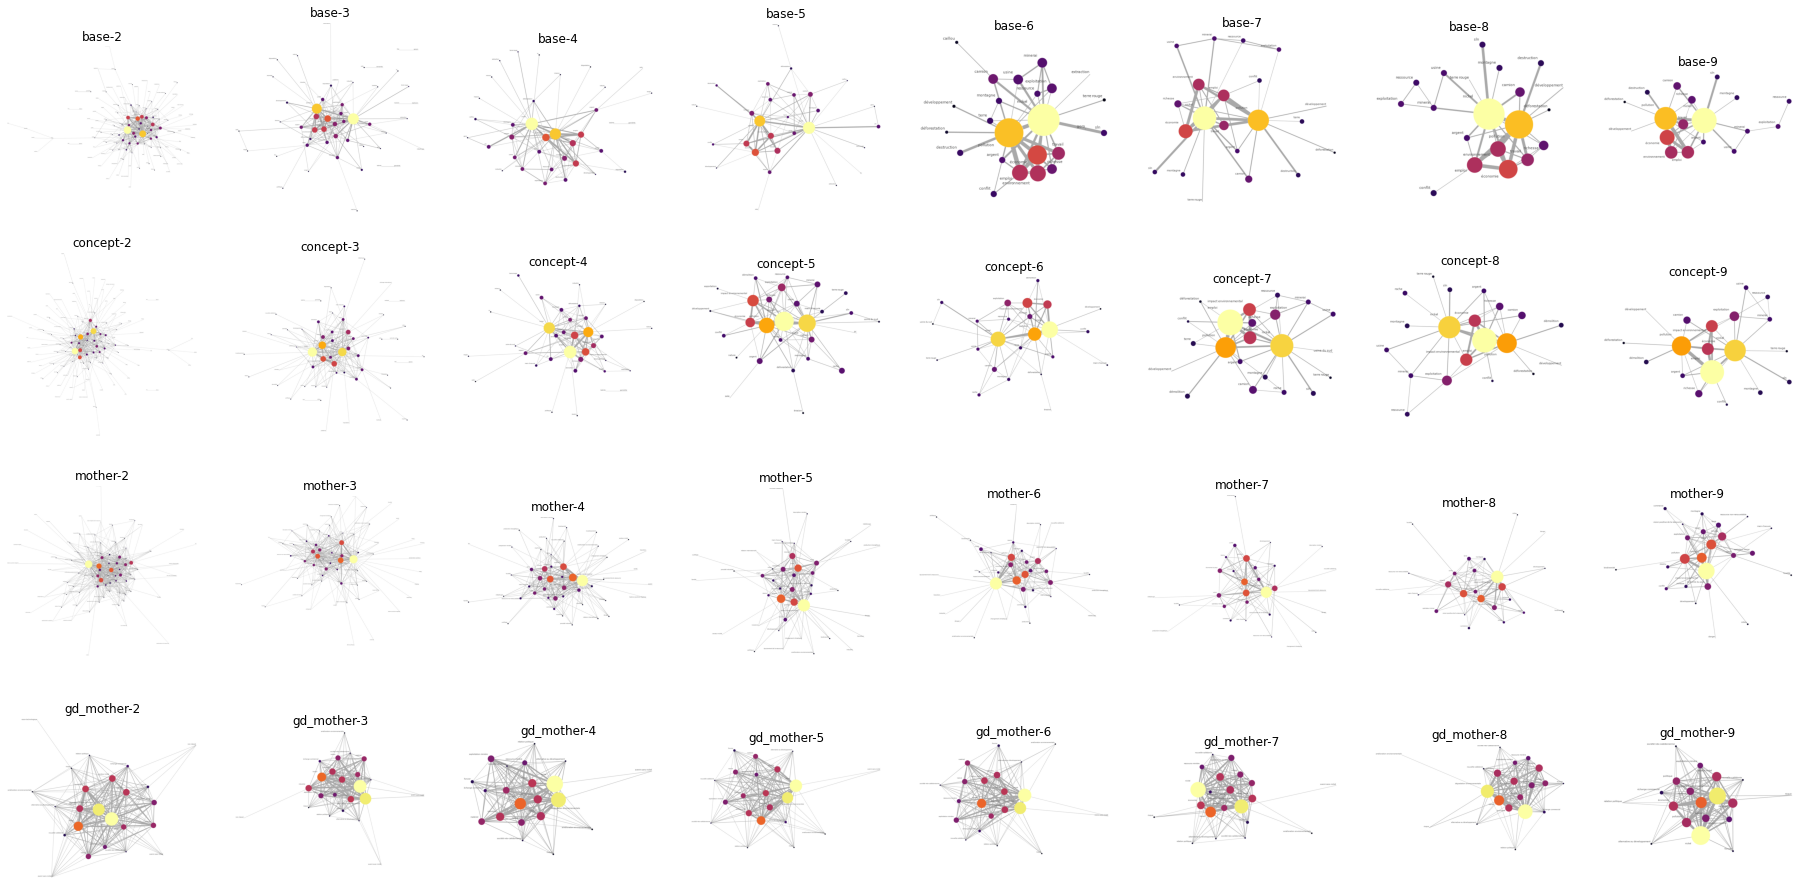

In [17]:
graphs_dir = Path("graphs/")
images = defaultdict(list)
for filename in graphs_dir.glob("*.png"):
    [*n, lv0, lv, we, th] = filename.stem.split("_")
    # print(lv, we, th, *n)
    images[("gd_" if lv0 =="gd" else "") + lv].append(filename)
for lvl in images:
    images[lvl] = sorted(images[lvl])

factor = 4
figsize=(factor*len(images["base"]), factor*len(images))
fig, axs = plt.subplots(nrows=len(images), ncols=len(images["base"]), figsize=figsize)
for nr, lvl in enumerate(LEVELS):
    # print(nr, lvl, imgs)
    imgs = images[lvl]
    for nc, img in enumerate(imgs):
        png = plt.imread(img)
        axs[nr, nc].axis('off')
        axs[nr, nc].set_title(f"{lvl}-{nc+2}")
        axs[nr, nc].imshow(png)


On peut aussi mettre sous forme de _heatmap_

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

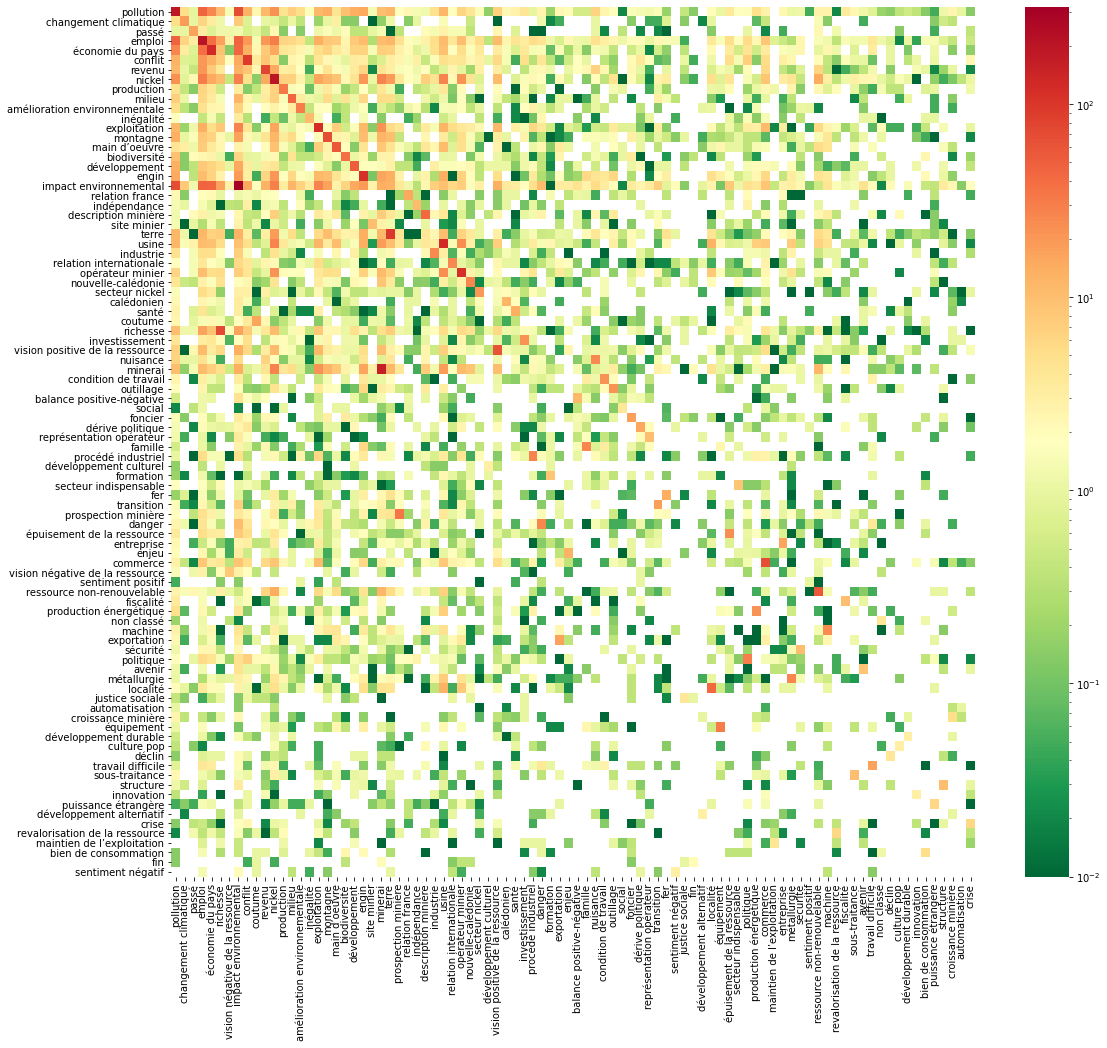

In [18]:
sns.despine()
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(df, xticklabels=True, yticklabels=True, cmap="RdYlGn_r", norm=LogNorm())

Enfin, pour mettre un peu de structure, on peut essayer de regrouper les termes qui ont des co-occurrences fréquentes et réordonner la _heatmap_ selon ces _clusters_ pour voire apparaitre des groupes.

On va supprimer tous les mots qui n'ont pas de co-occurences pour ce système de poids

In [19]:
not_nulls = df.to_numpy().diagonal() > 0.0
kept = [df.index[i] for i, b in enumerate(not_nulls) if b]

On lance le _clustering_ (ici un [KMeans++](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)) et on trie les lignes et les colonnes par rapport au résultat du _clustering_ (des regroupement de mots "proches")

In [20]:
df_1 = df.reindex(index=kept, columns=kept)
# le résultat du clustering
idx = vizu.clusterize(df_1, n_clusters=5, normalize=True, threshold= 0.05)
# on va réidenxer selont l'ordre donné par les clusters
sorted_idx = [word for _, words in sorted(idx.items()) for word in words]
df_2 = df_1.reindex(index=sorted_idx, columns=sorted_idx)

Le contenu des _clusters_, _id est_ les groupements de mots

In [21]:
for ix, clust in sorted(idx.items()):
    print(ix, clust)

0 ['pollution', 'emploi', 'économie du pays', 'conflit', 'développement', 'impact environnemental', 'richesse', 'investissement']
1 ['changement climatique', 'passé', 'amélioration environnementale', 'biodiversité', 'relation france', 'description minière', 'site minier', 'relation internationale', 'coutume', 'balance positive-négative', 'social', 'foncier', 'production énergétique', 'exportation', 'structure']
2 ['nickel', 'production', 'milieu', 'exploitation', 'montagne', 'main d’oeuvre', 'engin', 'terre', 'usine', 'opérateur minier', 'nouvelle-calédonie', 'vision positive de la ressource', 'fer', 'métallurgie']
3 ['inégalité', 'indépendance', 'épuisement de la ressource', 'politique', 'avenir']
4 ['secteur nickel', 'santé', 'nuisance', 'condition de travail', 'famille', 'formation', 'danger', 'travail difficile']


On va mettre une petite ligne entre les clusters et afficher la _heatmap_

<Figure size 432x288 with 0 Axes>

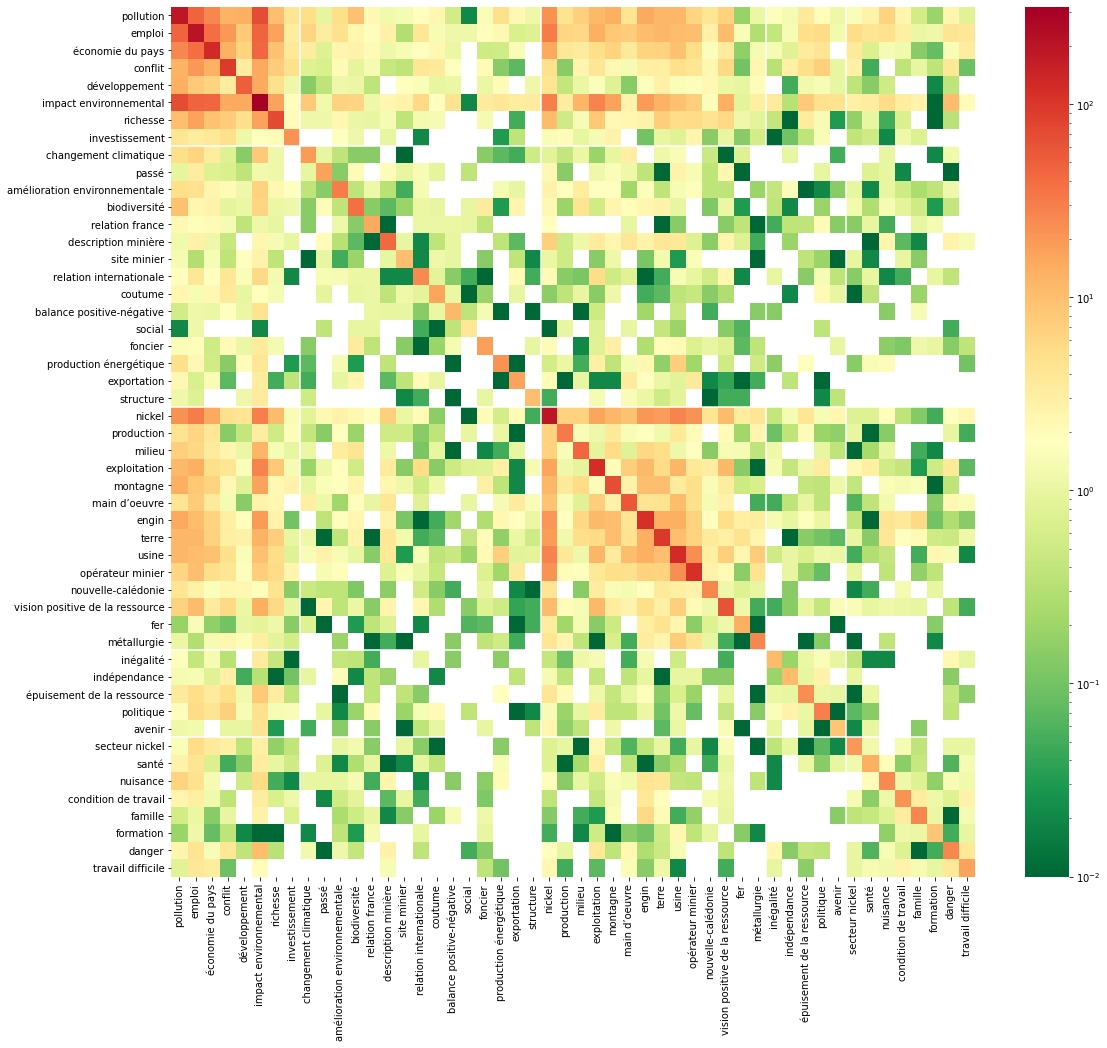

In [22]:
limits = list(accumulate([len(cat) for _, cat in sorted(idx.items())]))
# vizu.heatmap(df_2, limits)
sns.despine()
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(df_2, xticklabels=True, yticklabels=True, cmap="RdYlGn_r", norm=LogNorm())
ax.hlines(limits[:-1:], *ax.get_xlim(), colors="white")
ax.vlines(limits[:-1:], *ax.get_ylim(), colors="white")

Fin.